In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import toeplitz, solve

# Utility functions

## Survival Curves


In [2]:
def fixed_sf(n, lifetime):
    """Compute the survival function (SF) of a fixed lifetime distribution.
    The fixed lifetime distribution models a random variable that always
    takes on a fixed value of lifetime, after which it becomes 0.

    Args:
        n: The number of integers to evaluate the SF at.
        lifetime: fixed lifetime

    Returns:
        An array of the survival function (SF) values of the fixed lifetime
        distribution evaluated at integers from 0 to n-1.
    """
    pdf = np.zeros(n)
    pdf[0:lifetime] = 1
    return pdf


def weibull_sf(n, shape=5, loc=0, scale=20):
    """Compute the survival function (SF) of the Weibull distribution.

    Args:
        n: The number of integers to evaluate the SF at.
        shape: determine the skewness of the distribution
            (shape < 1 = skewed to the right, shape>1 = skewed to the left)
        loc: determine the minimum value that the distribution can take)
        scale: determine the spread of the distribution (scale = shift along x-axis)

    Returns:
        An array of the survival function (SF) values of the Weibull distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return weibull_min.sf(x, c=shape, loc=loc, scale=scale)


def normal_sf(n, loc=30, scale=10):
    """Compute the survival function (SF) of the normal distribution.

    Args:
        n: Number of integers to evaluate the SF at.
        loc: Mean of the normal distribution.
        scale: Standard deviation of the normal distribution.

    Returns:
        An array of the survival function (SF) values of the normal distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return norm.sf(x, loc=loc, scale=scale)


def geometric_sf(n, p=0.05, loc=0):
    """Compute the survival function (SF) of the geometric distribution. The geometric
    distribution models the number of trials that must be performed before the first success
    in a sequence of independent Bernoulli trials with the same probability of success.

    Args:
        n: The number of integers to evaluate the SF at.
        p: The probability of success for each Bernoulli trial.
        loc: shift along x-axis (i.e. the number of failures before the first success)

    Returns:
        An array of the survival function (SF) values of the geometric distribution
        evaluated at integers from 0 to n-1.
    """
    k = np.arange(n)
    return geom.sf(k=k, p=p, loc=loc)


def uniform_sf(n, loc=0, scale=10):
    """Compute the survival function (SF) of the continuous uniform distribution.
    The continuous uniform distribution models a random variable that can take
    any value in a fixed interval with equal probability.

    Args:
        n: The number of integers to evaluate the SF at.
        loc: The lower endpoint of the uniform distribution's support.
        scale: The width of the uniform distribution's support
            (i.e., the range between the lower and upper endpoints).

    Returns:
        An array of the survival function (SF) values of the uniform distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return uniform.sf(x, loc=loc, scale=scale)


def lognormal_sf(n, x=0.01, loc=0, scale=1):
    """Compute the survival function (SF) of the log-normal distribution.
    The log-normal distribution models a random variable whose natural logarithm
    follows a normal distribution.

    Args:
        n: The number of integers to evaluate the SF at.
        x: The value at which to evaluate the SF.
        loc: The mean of the logarithm of the distribution.
        scale: The standard deviation of the logarithm of the distribution.

    Returns:
        An array of the survival function (SF) values of the log-normal
        distribution evaluated at integers from 0 to n-1.
    """
    s = np.arange(n)
    result = lognorm.sf(x, s, loc=loc, scale=scale)
    result[0] = 1
    return result


def compute_survival_curve(kind, n, **kwargs):
    """Compute the survival function (SF) for a given statistical distribution

    Args:
        kind: The kind of distribution to use. Current options are:
            [fixed, weibull, normal, lognormal, geometric, uniform]
        n: The number of integers to evaluate the SF at.
        **kwargs: Additional distribution-specific parameters.

    Returns:
        An array of the survival function (SF) values of the specified distribution
        evaluated at integers from 0 to n-1.
    """
    survival_function = {
        "fixed": fixed_sf,
        "weibull": weibull_sf,
        "normal": normal_sf,
        "geometric": geometric_sf,
        "uniform": uniform_sf,
        "lognormal": lognormal_sf,
    }
    return survival_function[kind](n, **kwargs)


def compute_toeplitz_sf(arr):
    """Compute the (lower triangle) Toeplitz matrix of a survival curve.

    Args:
        arr: An array representing the survival curve.

    Returns:
        The Toeplitz matrix of the survival curve
    """
    n = len(arr)
    return toeplitz(arr) * np.tril(np.ones(shape=(n, n)))


def convert_to_df(time, survival_curve, cohort, inflow, outflow, stock, nas):
    """Convert the different (numpy) arrays representing a stock-flow model into DataFrames.

    Args:
        time: the time axis of the model.
        survival_curve: the survival curve used for the model.
        cohort: the cohort data of the model.
        inflow: the inflow data of the model.
        outflow: the outflow data of the model.
        stock: the stock data of the model.
        nas: The net addition to stock data of the model.

    Returns:
        A tuple containing two Pandas DataFrames:
        `timeseries` representing 5 vectors (survival curve, inflow, outflow, nas and stock)
            with time as index
        `cohort` matrix (time as both index and columns)
    """
    timeseries = pd.DataFrame(
        data={
            "survival_curve": survival_curve,
            "inflow": inflow,
            "outflow": outflow,
            "stock": stock,
            "nas": nas,
        },
        index=time,
    )
    cohort = pd.DataFrame(cohort, index=time, columns=time)
    return timeseries, cohort


## Stock Flow Model


In [3]:
def flow_driven_model(time, inflow, sf_kind="normal", stock_ini=0, **kwargs):
    """Computes a stock-flow model given inflow

    Args:
        time (np.ndarray): 1D array of time values
        inflow (np.ndarray): 1D array of inflow values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'normal').
            Valid options are 'fixed', 'weibull', 'normal', 'geometric', 'uniform', and 'lognormal'.
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames:
        - timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        - cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    cohort = inflow * survival_toeplitz
    stock = cohort.sum(axis=1)  # EXTRA STEP COMPARED WITH STOCK-DRIVEN
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


def stock_driven_model(time, stock, sf_kind="normal", stock_ini=0, **kwargs):
    """Computes a stock-flow model given stocks

    Args:
        time (np.ndarray): 1D array of time values
        stock (np.ndarray): 1D array of stock values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'normal').
            Valid options are 'fixed', 'weibull', 'normal', 'geometric', 'uniform', and 'lognormal'.
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames:
        - timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        - cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    inflow = solve(survival_toeplitz, stock)  # EXTRA STEP COMPARED WITH FLOW-DRIVEN
    cohort = inflow * survival_toeplitz
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


<hr>

# Question 1

**Slide 45 of the week 2 presentation file shows various pairs of survival curves and outflow curves. Choose three of these six pairs, suggest a type of material or product that you think has this behavior. We saw some examples in slide 46, but think of new examples!**

**Example of product with Weibull distribution lifetime:**

Galvanized Zinc in pipes and wire (scale = 23 years and shape = 4 years)
Source: Yan, L., Wang, A., Chen, Q., & Li, J. (2013). Dynamic material flow analysis of zinc resources in China. Resources, conservation and recycling, 75, 23-31.

lithium, Nickel and Cobal present in smartphones (scale = 3.5 years and shape = 2.2 years)
Source: Zhilyaev, D., Cimpan, C., Cao, Z., Liu, G., Askegaard, S., & Wenzel, H. (2021). The living, the dead, and the obsolete: A characterization of lifetime and stock of ICT products in Denmark. Resources, Conservation and Recycling, 164, 105117.

**Example of product with normal distribution**

Concrete in building (mean = 50 years and standard deviation = 10 years)
Source: Hu, M., Van Der Voet, E., & Huppes, G. (2010). Dynamic material flow analysis for strategic construction and demolition waste management in Beijing. Journal of Industrial Ecology, 14(3), 440-456.

**Example of product with log-normal distribution lfietime**

Plastic bags and food packaging (mean = 0.1 year and stdv = 0.5 year)
Source: Kan, M. (2021). Dynamic flows and stocks of plastics in the United States and pathways towards zero plastic pollution by 2050 (Doctoral dissertation).


<hr>

# Question 2

**Which survival curve / outflow curve pair describes this behavior? Change the survival curve and re-run the model, and show the results. Shortly describe the differences in stocks and outflows between the original results and the new results: Will he accumulate more stocks? Will he generate more outflows?**


In [4]:
# Load the data
FILE_PATH = "../../data/MFA_II_tutorial_II.xlsx"
data = pd.read_excel(FILE_PATH, sheet_name=None)
year = data["inflow_driven"]["year"].values
inflow = data["inflow_driven"]["inflow"].values

In [5]:
# Run the model under both conditions

# parameters for uniform distribution
lifetime_scale = 10

# parameters for normal distribution
lifetime_avg = 30
lifetime_stdv = 10

# Re-run the model with above parameters
timeseries_unif, cohort_unif = flow_driven_model(
    time=year, inflow=inflow, sf_kind="uniform", scale=lifetime_scale
)
timeseries_norm, cohort_norm = flow_driven_model(
    time=year, inflow=inflow, sf_kind="normal", loc=lifetime_avg, scale=lifetime_stdv
)

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


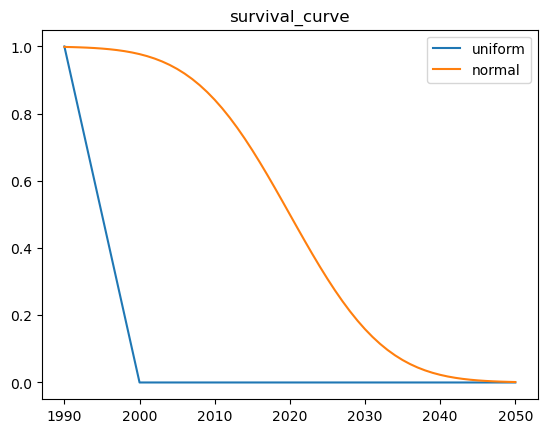

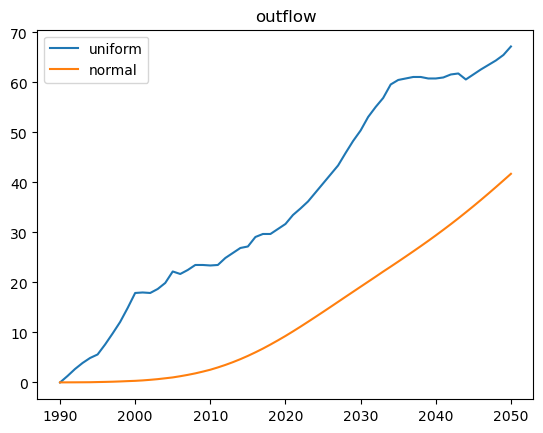

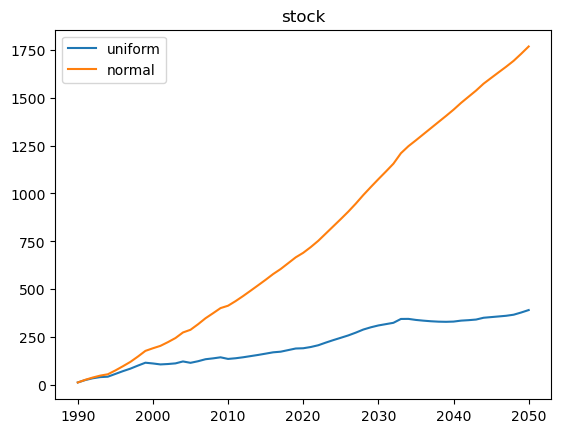

In [6]:
for column in ["survival_curve", "outflow", "stock"]:
    df_lst = [timeseries_unif[column], timeseries_norm[column]]
    print(pd.concat(df_lst, axis=1, keys=["uniform", "normal"]).plot(title=column))

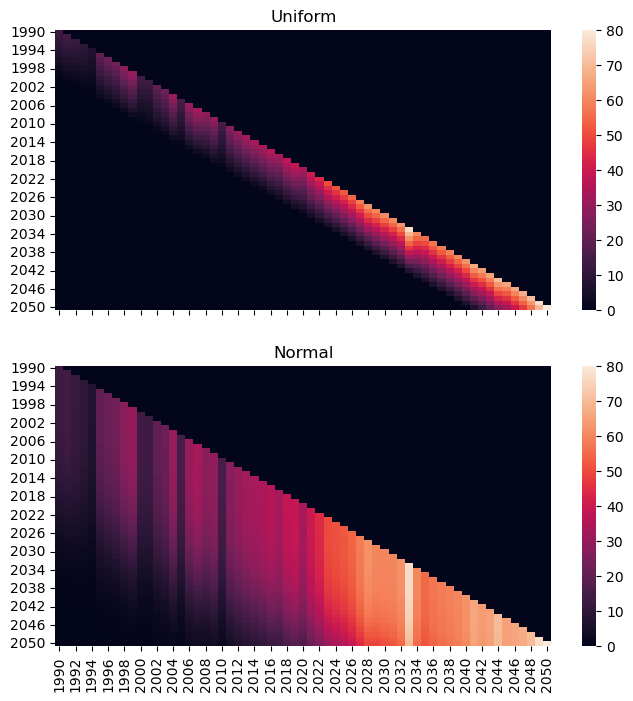

In [7]:
# Display the Toepelitz cohort matrix
fig, ax = plt.subplots(figsize=(8, 8), nrows=2, sharex=True, sharey=True)

vmax = max(cohort_unif.values.max(), cohort_norm.values.max())

sns.heatmap(cohort_unif, annot=False, ax=ax[0], vmax=vmax)
sns.heatmap(cohort_norm, annot=False, ax=ax[1], vmax=vmax)

ax[0].set(title="Uniform")
ax[1].set(title="Normal")

plt.show()

We can see from the graphs that the outflow grows much faster for the uniform distribution.  
As a consequence, the stock does not build up as much.  
This is clearly reflected in the Cohort Toepelitz matrices above.


<hr>

# Question 3

**Use a Weibull distribution to create a curve that describes this, re-run the model and show the results. Shortly describe the differences in stocks and outflows between question 2 and question 3.**


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


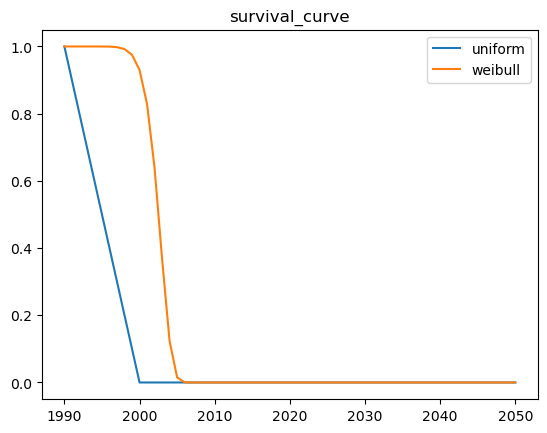

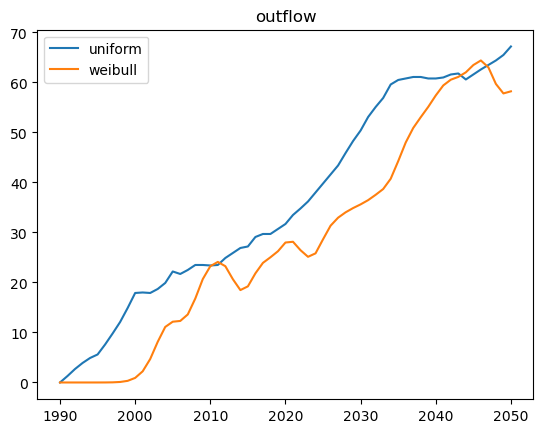

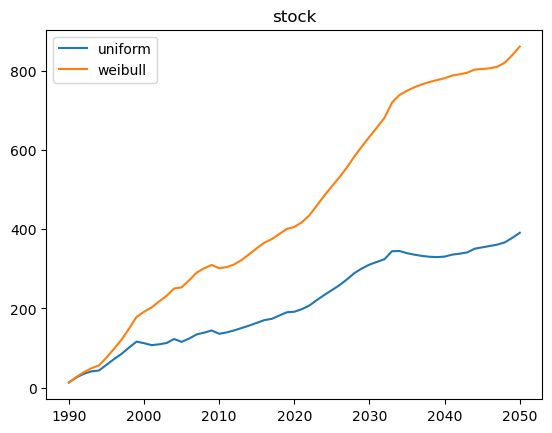

In [8]:
# Parameters for the weibull distribution
shape = 10
scale = 13

# Run the model with above parameters
timeseries_wb, cohort_wb = flow_driven_model(
    time=year, inflow=inflow, sf_kind="weibull", shape=shape, scale=scale
)

# Display the result in comparison with the uniform distribution of above
for column in ["survival_curve", "outflow", "stock"]:
    df_lst = [timeseries_unif[column], timeseries_wb[column]]
    print(pd.concat(df_lst, axis=1, keys=["uniform", "weibull"]).plot(title=column))

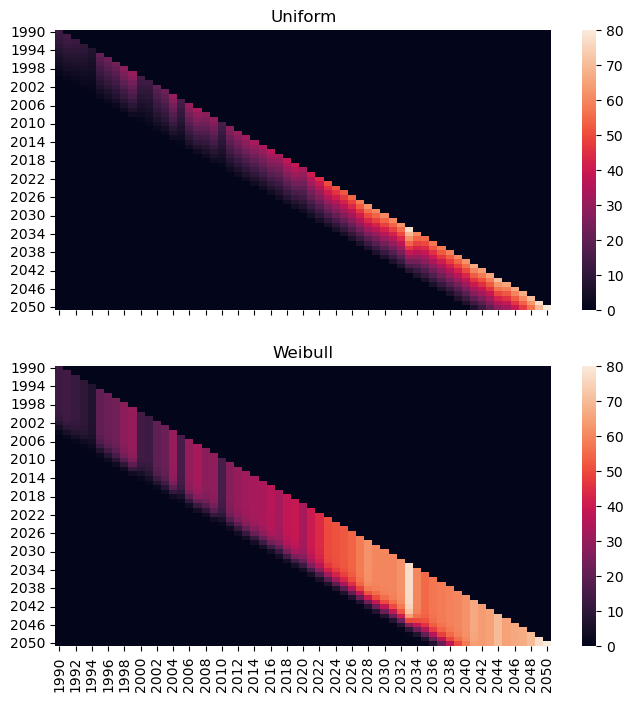

In [9]:
# Display the Toepelitz cohort matrix
fig, ax = plt.subplots(figsize=(8, 8), nrows=2, sharex=True, sharey=True)

vmax = max(cohort_unif.values.max(), cohort_wb.values.max())

sns.heatmap(cohort_unif, annot=False, ax=ax[0], vmax=vmax)
sns.heatmap(cohort_wb, annot=False, ax=ax[1], vmax=vmax)

ax[0].set(title="Uniform")
ax[1].set(title="Weibull")

plt.show()

The outflows are much more similar, although the outflow for the weibull is generally lower, which lead to a longer residence time for the cohort, which is display in the Cohort Toepelitz Matrix.


<hr>

# Question 4

**Change the input data from 2030-2050 to 503 plates, and rerun the model with the default normal distribution. Describe the changes to the inflows, outflows, and stocks compared to the default.**


In [10]:
# modify stock to 503 for the period 2030-2050 (in a new DataFrame)
new_data = data["stock_driven"].copy()
MASK = new_data.query("year >= 2030 and year <= 2050").index
new_data.loc[MASK, "stock"] = 503

# get numpy array
year = data["stock_driven"]["year"].values
stock = data["stock_driven"]["stock"].values
stock_capped = new_data["stock"].values

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


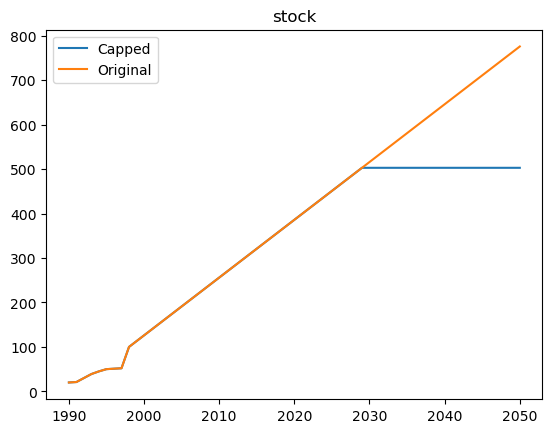

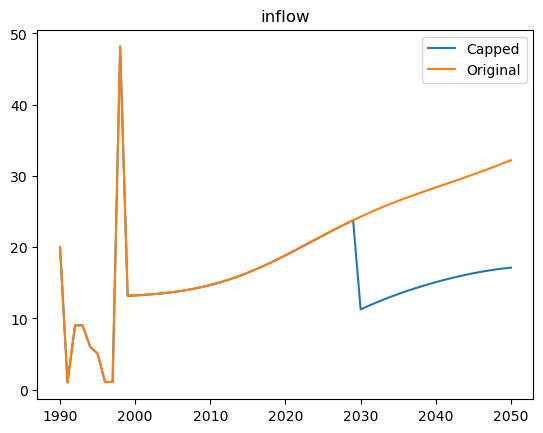

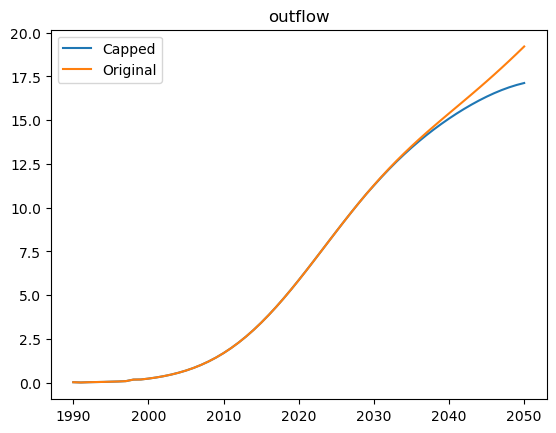

In [11]:
# parameters for normal distribution
lifetime_avg = 30
lifetime_stdv = 10

# Run the model with above parameters
timeseries_capped, cohort_capped = stock_driven_model(
    time=year,
    stock=stock_capped,
    sf_kind="normal",
    loc=lifetime_avg,
    scale=lifetime_stdv,
)

timeseries, cohort = stock_driven_model(
    time=year, stock=stock, sf_kind="normal", loc=lifetime_avg, scale=lifetime_stdv
)

# Display the result in comparison with the uniform distribution of above
for column in ["stock", "inflow", "outflow"]:
    df_lst = [timeseries_capped[column], timeseries[column]]
    print(pd.concat(df_lst, axis=1, keys=["Capped", "Original"]).plot(title=column))

We can see a big dip in the inflows from 2030 onwards.  
This makes sense since the collector can no longer buy that many plates due to storage limitations.  
This is in turn leads to a decreasing outflows, but the effect comes much later.


<hr>

# Question 5

**After exactly 45 years, they simply crumble to dust. Model this with the appropriate pair of survival curve and outflow curve, and compare the inflows, outflows, and stocks in such a case.**


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


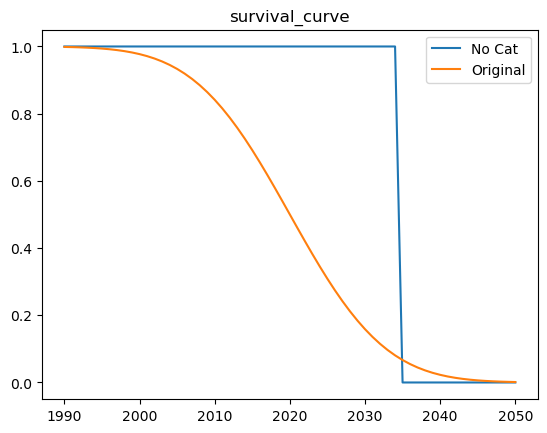

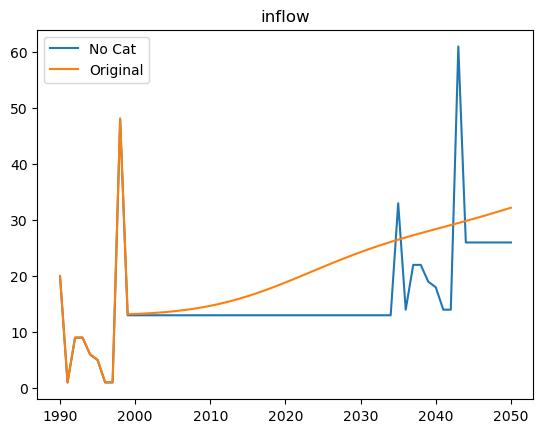

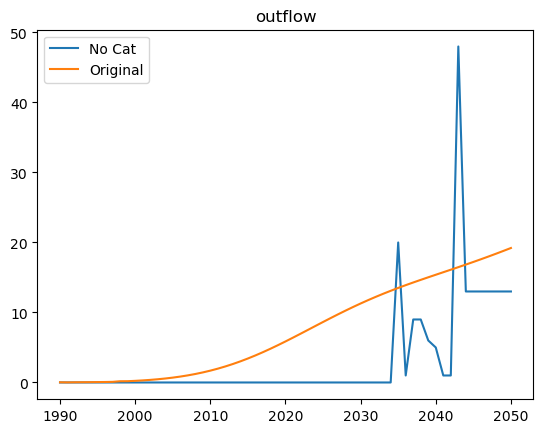

In [12]:
# Re-run the model with the new distribution
lifetime = 45
timeseries_noCat, cohort_noCat = stock_driven_model(
    time=year, stock=stock, sf_kind="fixed", lifetime=lifetime
)

# Display the result in comparison with the uniform distribution of above
for column in ["survival_curve", "inflow", "outflow"]:
    df_lst = [timeseries_noCat[column], timeseries[column]]
    print(pd.concat(df_lst, axis=1, keys=["No Cat", "Original"]).plot(title=column))

Outflows are identical to inflows (but delayed by the lifetime of the plates)  
Inflows are delayed by 45 years, and shifted by the an amount corresponding to...


<hr>

# Question 6

**In which of the previous two scenarios will the collector have more to buy more plates (i.e. more inflows): if she limits her stock to 503 from 2030 on, or if she keeps accumulating stocks as in the original data but gives away her cat?**


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


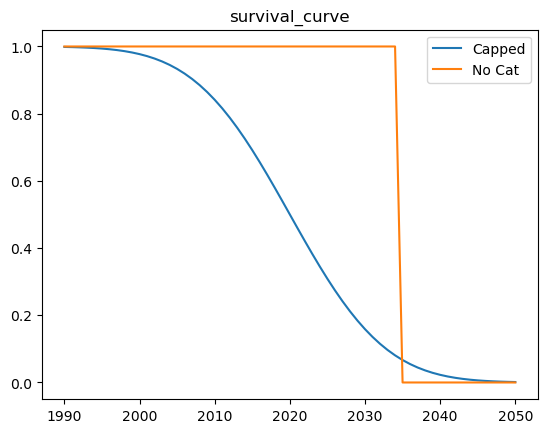

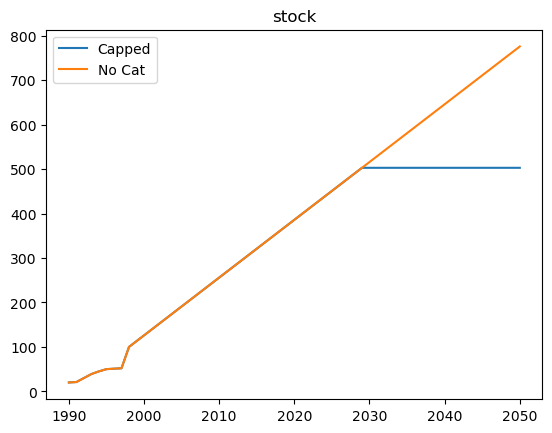

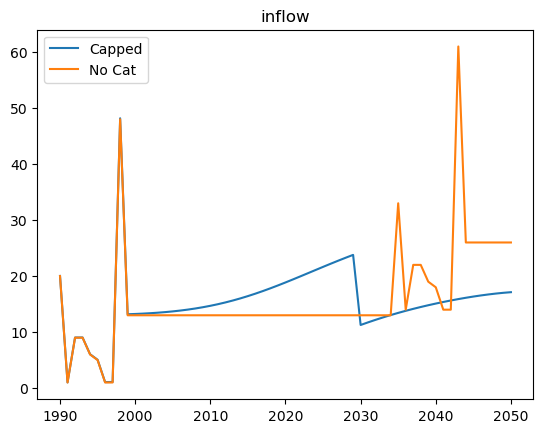

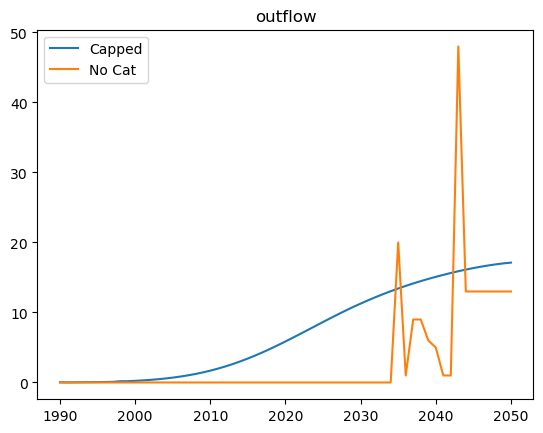

In [13]:
# Display the result in comparison with the uniform distribution of above
for column in ["survival_curve", "stock", "inflow", "outflow"]:
    df_lst = [timeseries_capped[column], timeseries_noCat[column]]
    print(pd.concat(df_lst, axis=1, keys=["Capped", "No Cat"]).plot(title=column))

It depends on the timeframe we are looking at:

- for 2000-2030: its better not to have a cat
- for 2030-2050: she better stop accumulating plates.


<hr>


# Question 7

**Show that the Python models and Excel models get the same results when you use the same data inputs,
or describe any differences**


In [14]:
# STOCK DRIVEN MODEL

FILE_PATH_sd_surv = "../../course_materials/stock_driven_model_surv.xlsx"

# Get Data Input
input_sd_surv = pd.read_excel(
    FILE_PATH_sd_surv,
    sheet_name="Data_Inputs",
    header=2,
    index_col=0,
    usecols="B,C,E,F,I",
)
stock = input_sd_surv["stock (Mt)"].fillna(0).values
year = input_sd_surv.index.values

# Get Data Output
output_sd_surv = pd.read_excel(
    FILE_PATH_sd_surv,
    sheet_name="Cohort_survival_matrix_&Outputs",
    header=2,
    index_col=4,
)
outflow = output_sd_surv["outflows (Mt/y)"].fillna(0).values
nas = output_sd_surv["nas (Mt/y)"].fillna(0).values
inflows = output_sd_surv["inflows (Mt/y)"].fillna(0).values
cohort_xlsx = output_sd_surv[output_sd_surv.index].fillna(0).values

# Uncomment to check normal distribution parameters
# print(input_sd_surv.head(2))

# Define parameters
lifetime_avg = 30
lifetime_stdv = 10

# Run the model

timeseries, cohort = stock_driven_model(
    time=year, stock=stock, sf_kind="normal", loc=lifetime_avg, scale=lifetime_stdv
)

print(np.allclose(outflow, timeseries["outflow"].values))
print(np.allclose(nas, timeseries["nas"].values))
print(np.allclose(stock, timeseries["stock"].values))
print(np.allclose(cohort_xlsx, cohort.values))

True
True
True
False


In [15]:
print(~np.isclose(cohort_xlsx, cohort.values))

[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]


We can see that for the Stock Driven model, the cohorts on the diagonal are different (excel is not able to handle sequential instructions and raise a circular reference error).


In [16]:
# FLOW DRIVEN MODEL

FILE_PATH_fd_surv = "../../course_materials/flow_driven_model_surv.xlsx"

# Get Data Input
input_fd_surv = pd.read_excel(
    FILE_PATH_fd_surv,
    sheet_name="Data_Inputs",
    header=2,
    index_col=0,
    usecols="B,C,E,F,I",
)
inflow = input_fd_surv["inflows (Mt/y):"].fillna(0).values
year = input_fd_surv.index.values

# Get Data Output
output_fd_surv = pd.read_excel(
    FILE_PATH_fd_surv,
    sheet_name="Cohort_survival_matrix_&Outputs",
    header=2,
    index_col=4,
)
outflow = output_fd_surv["outflows (Mt/y)"].fillna(0).values
nas = output_fd_surv["nas (Mt/y)"].fillna(0).values
stock = output_fd_surv["stock (Mt)"].fillna(0).values
cohort_xlsx = output_fd_surv[output_fd_surv.index].fillna(0).values

# Uncomment to check normal distribution parameters
# print(input_fd_surv.head(2))

# Define parameters
lifetime_avg = 30
lifetime_stdv = 10

# Run the model

timeseries, cohort = flow_driven_model(
    time=year, inflow=inflow, sf_kind="normal", loc=lifetime_avg, scale=lifetime_stdv
)

print(np.allclose(outflow, timeseries["outflow"].values))
print(np.allclose(nas, timeseries["nas"].values))
print(np.allclose(stock, timeseries["stock"].values))
print(np.allclose(cohort_xlsx, cohort.values))

True
True
True
True


<hr>

# Question 8


<Axes: >

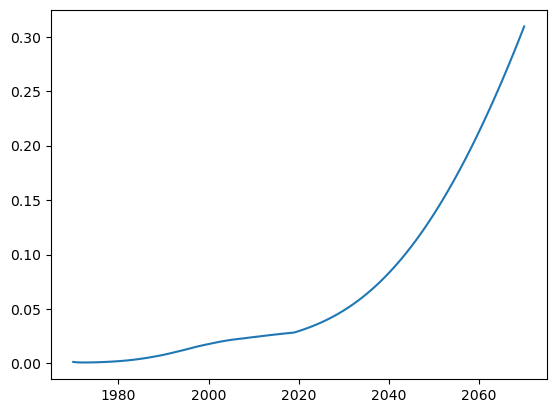

In [17]:
# Using the calculated data from the flow-model of question 7
(timeseries["outflow"] / timeseries["stock"]).plot()

<Axes: >

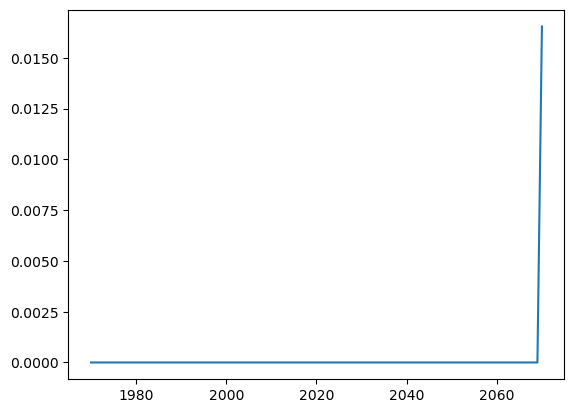

In [18]:
ts = flow_driven_model(
    time=year,
    inflow=inflow,
    sf_kind="fixed",
    lifetime=100,  # loc=lifetime_avg, scale=lifetime_stdv
)[0]
(ts["outflow"] / ts["stock"]).plot()

<Axes: >

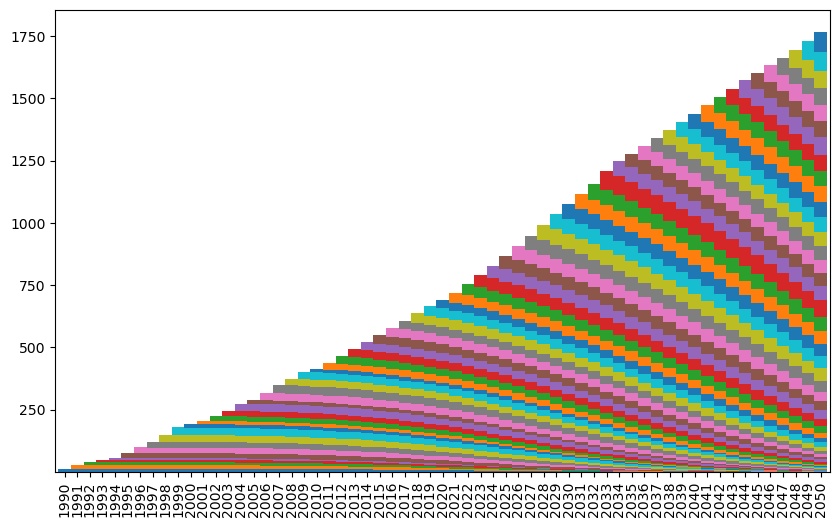

In [21]:
cohort_norm.plot(kind="bar", stacked=True, legend=False, width=1, figsize=(10, 6))
